In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [10]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [11]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [12]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# LSTM1 - CNN1

In [14]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 dropout_3 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4032)              0         
                                                      

In [15]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 9s 30ms/step - loss: 0.7732 - accuracy: 0.6895 - val_loss: 0.4725 - val_accuracy: 0.8418
Epoch 2/10
58/58 [==============================] - 1s 13ms/step - loss: 0.3126 - accuracy: 0.8885 - val_loss: 0.2394 - val_accuracy: 0.9248
Epoch 3/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1713 - accuracy: 0.9339 - val_loss: 0.1716 - val_accuracy: 0.9288
Epoch 4/10
58/58 [==============================] - 1s 23ms/step - loss: 0.1495 - accuracy: 0.9382 - val_loss: 0.1475 - val_accuracy: 0.9533
Epoch 5/10
58/58 [==============================] - 2s 29ms/step - loss: 0.1230 - accuracy: 0.9498 - val_loss: 0.1365 - val_accuracy: 0.9587
Epoch 6/10
58/58 [==============================] - 2s 28ms/step - loss: 0.1161 - accuracy: 0.9479 - val_loss: 0.1202 - val_accuracy: 0.9538
Epoch 7/10
58/58 [==============================] - 2s 29ms/step - loss: 0.1070 - accuracy: 0.9536 - val_loss: 0.1105 - val_accuracy: 0.9601
Epoch 8/10
58

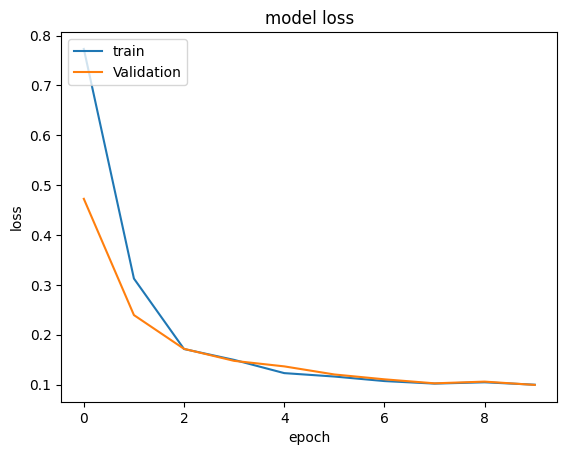

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

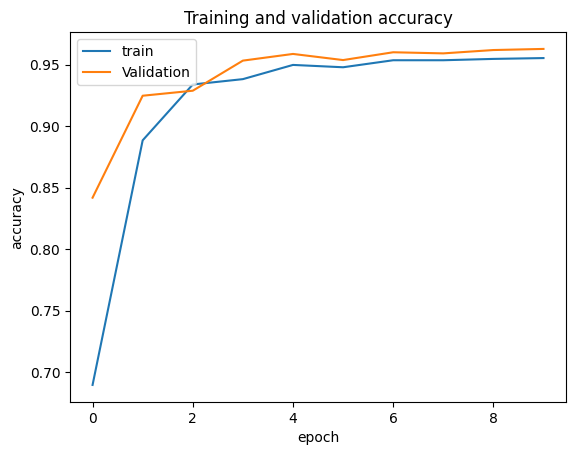

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 8ms/step
[[467   3  26   0   0   0]
 [  1 464   6   0   0   0]
 [  0   0 420   0   0   0]
 [  0  20   0 418  48   5]
 [  1   3   0  93 435   0]
 [  0  27   0   0   0 510]]
0.9209365456396336
0.9207235575862638
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       496
           1       0.90      0.99      0.94       471
           2       0.93      1.00      0.96       420
           3       0.82      0.85      0.83       491
           4       0.90      0.82      0.86       532
           5       0.99      0.95      0.97       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

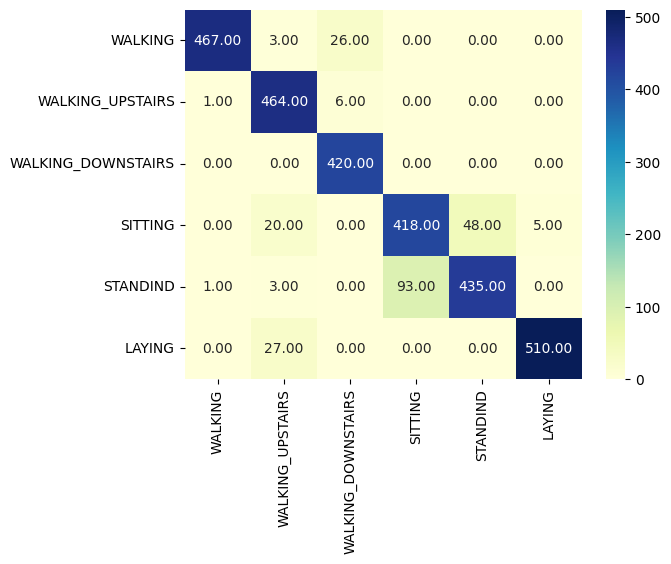

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM 1 - CNN2



In [19]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 conv1d_3 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_5 (Dropout)         (None, 124, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 62, 64)            0         
 g1D)                                                            
                                                      

In [20]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 10s 45ms/step - loss: 0.7069 - accuracy: 0.7116 - val_loss: 0.4473 - val_accuracy: 0.8436
Epoch 2/10
58/58 [==============================] - 1s 19ms/step - loss: 0.2746 - accuracy: 0.8955 - val_loss: 0.1887 - val_accuracy: 0.9361
Epoch 3/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1569 - accuracy: 0.9372 - val_loss: 0.1998 - val_accuracy: 0.9320
Epoch 4/10
58/58 [==============================] - 1s 14ms/step - loss: 0.1285 - accuracy: 0.9460 - val_loss: 0.1303 - val_accuracy: 0.9461
Epoch 5/10
58/58 [==============================] - 1s 16ms/step - loss: 0.1229 - accuracy: 0.9465 - val_loss: 0.1191 - val_accuracy: 0.9583
Epoch 6/10
58/58 [==============================] - 1s 17ms/step - loss: 0.1078 - accuracy: 0.9531 - val_loss: 0.1133 - val_accuracy: 0.9574
Epoch 7/10
58/58 [==============================] - 1s 17ms/step - loss: 0.1070 - accuracy: 0.9508 - val_loss: 0.1387 - val_accuracy: 0.9365
Epoch 8/10
5

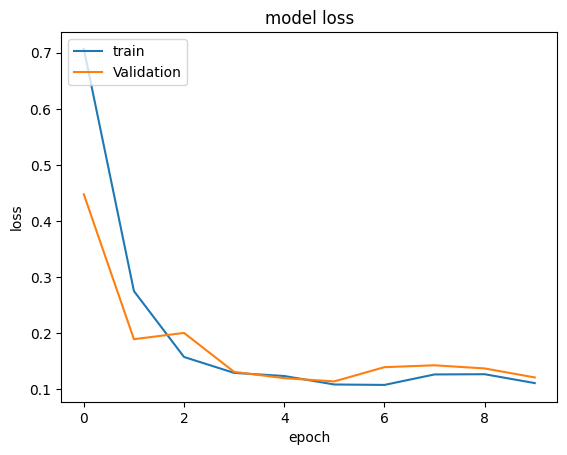

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

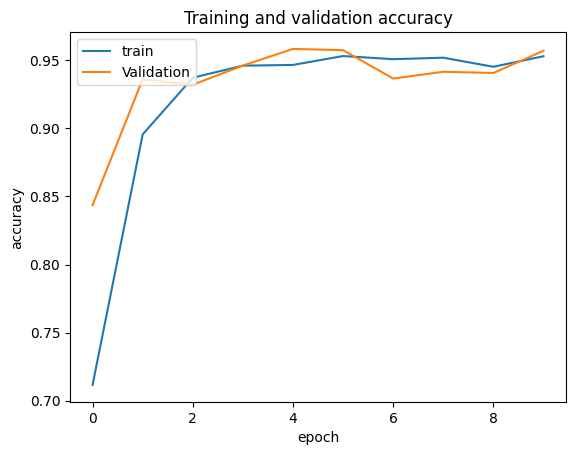

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 6ms/step
[[457  26  13   0   0   0]
 [  2 463   6   0   0   0]
 [  0  12 408   0   0   0]
 [  0  25   0 362 104   0]
 [  4   1   0  47 480   0]
 [  0  27   0   0   0 510]]
0.9093993892093655
0.908934727227983
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       496
           1       0.84      0.98      0.90       471
           2       0.96      0.97      0.96       420
           3       0.89      0.74      0.80       491
           4       0.82      0.90      0.86       532
           5       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

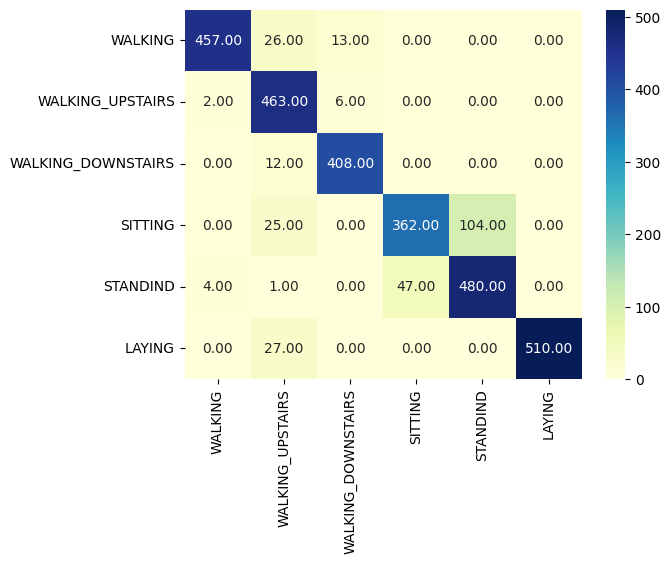

In [23]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2 - CNN1

In [24]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_6 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 dropout_8 (Dropout)         (None, 126, 64)           0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 63, 64)           

In [25]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 6s 40ms/step - loss: 0.8494 - accuracy: 0.6499 - val_loss: 0.5183 - val_accuracy: 0.8169
Epoch 2/10
58/58 [==============================] - 1s 23ms/step - loss: 0.3546 - accuracy: 0.8651 - val_loss: 0.2878 - val_accuracy: 0.9075
Epoch 3/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1978 - accuracy: 0.9225 - val_loss: 0.1818 - val_accuracy: 0.9361
Epoch 4/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1568 - accuracy: 0.9353 - val_loss: 0.1259 - val_accuracy: 0.9533
Epoch 5/10
58/58 [==============================] - 1s 25ms/step - loss: 0.1333 - accuracy: 0.9455 - val_loss: 0.1336 - val_accuracy: 0.9442
Epoch 6/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1222 - accuracy: 0.9476 - val_loss: 0.1241 - val_accuracy: 0.9515
Epoch 7/10
58/58 [==============================] - 1s 23ms/step - loss: 0.1155 - accuracy: 0.9508 - val_loss: 0.1438 - val_accuracy: 0.9510
Epoch 8/10
58

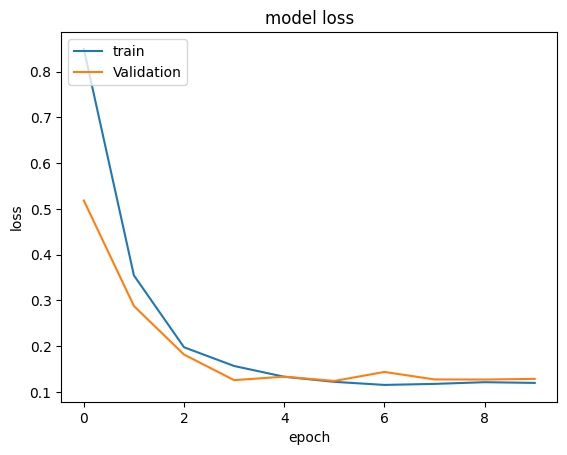

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

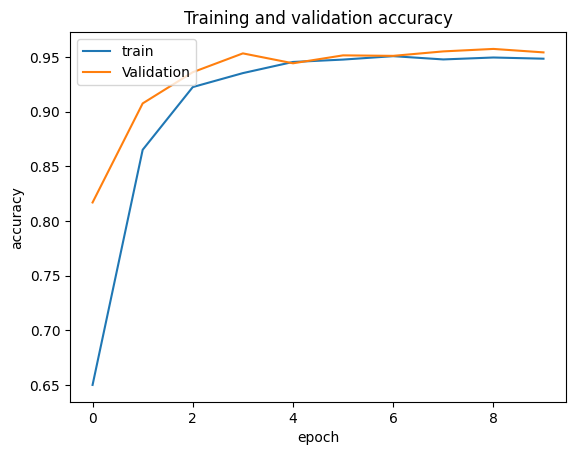

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 5ms/step
[[407  61  27   1   0   0]
 [  1 441  25   0   0   4]
 [  1   0 419   0   0   0]
 [  3  25   0 415  48   0]
 [ 11   0   0  82 439   0]
 [  0  26   0   0   0 511]]
0.8931116389548693
0.8931685588899504
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       496
           1       0.80      0.94      0.86       471
           2       0.89      1.00      0.94       420
           3       0.83      0.85      0.84       491
           4       0.90      0.83      0.86       532
           5       0.99      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.90      0.90      0.89      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

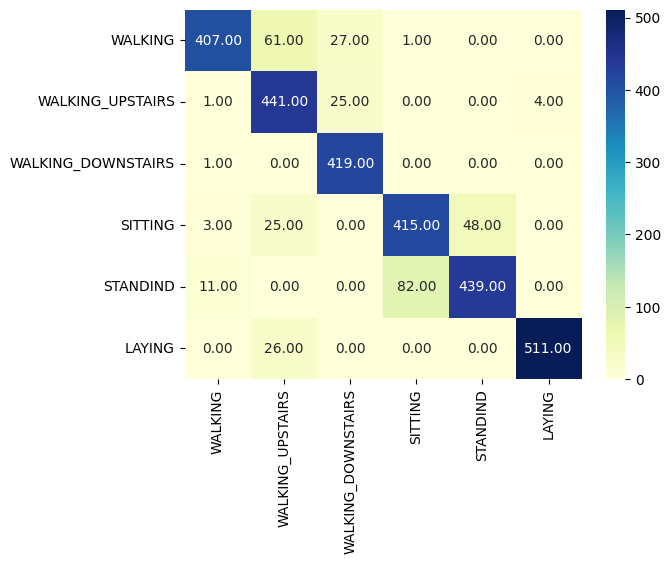

In [28]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2 - CNN2

In [29]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_9 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_10 (Dropout)        (None, 128, 128)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 conv1d_6 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_11 (Dropout)        (None, 124, 64)          

In [30]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 7s 39ms/step - loss: 0.9569 - accuracy: 0.5928 - val_loss: 0.5319 - val_accuracy: 0.8028
Epoch 2/10
58/58 [==============================] - 1s 24ms/step - loss: 0.3694 - accuracy: 0.8640 - val_loss: 0.2695 - val_accuracy: 0.9039
Epoch 3/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1946 - accuracy: 0.9212 - val_loss: 0.1785 - val_accuracy: 0.9302
Epoch 4/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1557 - accuracy: 0.9366 - val_loss: 0.1670 - val_accuracy: 0.9411
Epoch 5/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1359 - accuracy: 0.9427 - val_loss: 0.1441 - val_accuracy: 0.9338
Epoch 6/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1281 - accuracy: 0.9467 - val_loss: 0.1205 - val_accuracy: 0.9492
Epoch 7/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1122 - accuracy: 0.9529 - val_loss: 0.1150 - val_accuracy: 0.9569
Epoch 8/10
58

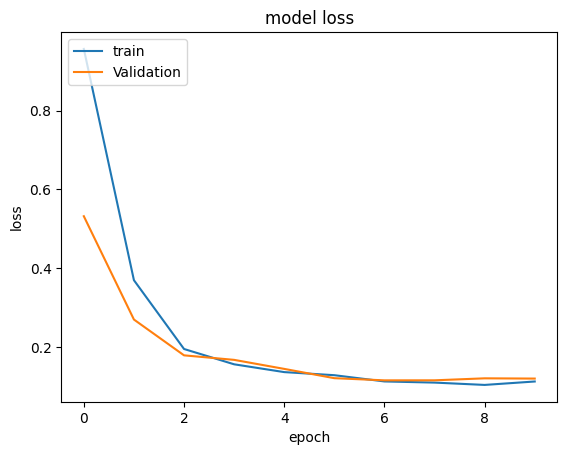

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

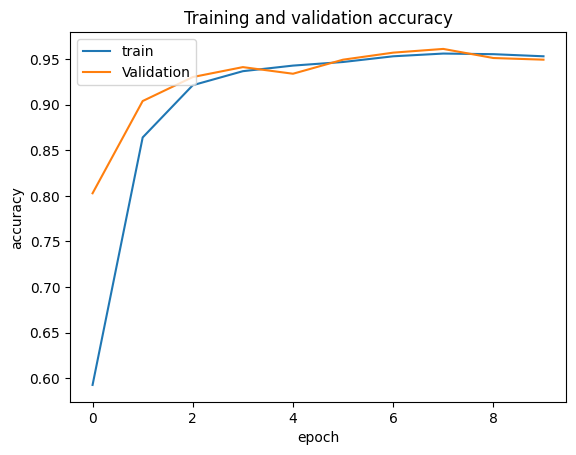

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 5ms/step
[[463   1  32   0   0   0]
 [  2 458  11   0   0   0]
 [  0   1 419   0   0   0]
 [  3  19   2 362 104   1]
 [  3   0   0  70 459   0]
 [  0   4   0   0   0 533]]
0.9141499830335935
0.9131292971597496
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       496
           1       0.95      0.97      0.96       471
           2       0.90      1.00      0.95       420
           3       0.84      0.74      0.78       491
           4       0.82      0.86      0.84       532
           5       1.00      0.99      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.92      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

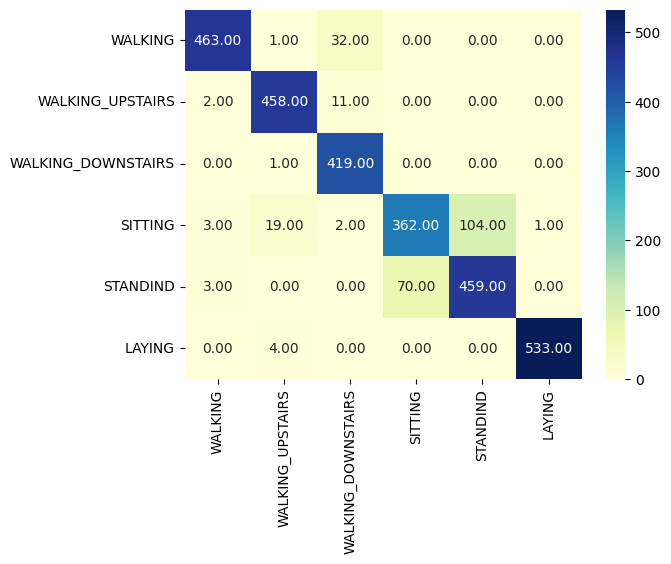

In [33]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')